# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_dark'

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/eth.csv')
print(df.shape)
df

(2134, 7)


,Date,Open_,High,Low,Close__,Volume,MarketCap
0,"Jun 08, 2021","$2,594.60","$2,620.85","$2,315.55","$2,517.44","$41,909,736,778","$292,557,075,207"
1,"Jun 07, 2021","$2,713.05","$2,845.19","$2,584.00","$2,590.26","$30,600,111,277","$300,985,400,826"
2,"Jun 06, 2021","$2,629.75","$2,743.44","$2,616.16","$2,715.09","$25,311,639,414","$315,453,931,558"
3,"Jun 05, 2021","$2,691.62","$2,817.48","$2,558.23","$2,630.58","$30,496,672,724","$305,598,725,249"
4,"Jun 04, 2021","$2,857.17","$2,857.17","$2,562.64","$2,688.19","$34,173,841,611","$312,256,566,095"
...,...,...,...,...,...,...,...
2129,"Aug 10, 2015",$0.71,$0.73,$0.64,$0.71,"$405,283","$42,818,364"
2130,"Aug 09, 2015",$0.71,$0.88,$0.63,$0.7,"$532,170","$42,399,574"
2131,"Aug 08, 2015",$2.79,$2.80,$0.71,$0.75,"$674,188","$45,486,894"
2132,"Aug 07, 2015",$2.83,$3.54,$2.52,$2.77,"$164,329","$166,610,555"


# Goal and Data Description

## Data Source

This data was scraped from CoinMarketCap.com using the webscraper Octoparse. The webpages used ajax syntax for the "load page" button, and therfore ajax timeout time needed to be applied in order to properly extract the data. This data is only concerned with Ethereum, and no other coin or blockchain.

## Features

The data includes the following features:

1. Open
2. High
3. Low
4. Close 
5. Volume
6. Market Cap
<br>

This dataset provides a timeline of eth prices and related data from August 7th, 2015 to June 8th, 2021.
<br>


# Data Preprocessing

In [2]:
# Convert the 'Date' column to a datetime datatype and set it as the index, then sort the index
df['Date'] = pd.to_datetime(df.Date)
df.set_index(df.Date, inplace=True)
df.drop(df.tail(1).index, inplace=True)
df = df.sort_index()

# Drop the Date column
df = df.drop(columns=['Date'], axis=1)

## Remove dollar signs and commas

# Specify columns
cols = list(df.columns)

# Replace the dollar signs and commas with empty character
df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)

## Convert all entries to numerical data type
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Rename the columns with unconventinal text in the string
df.rename(columns={'Open_':'Open', 'Close__':'Close'}, inplace=True)

# Find missing values
print(df.isna().sum())

# There are very few missing values, so we will drop all of them
df = df.dropna()

# Check for duplicates in index
print(df.index.duplicated().sum())

# Check for duplicates in columns
print(df.duplicated().sum())

# Check how much of the data are duplicates overall
print(df[df.duplicated()==True].shape[0] / df.shape[0])

# There are no duplicates but let's use the drop_duplciates method just as good practice
df = df.drop_duplicates()
print(df.shape)
df.info()

Open         0
High         0
Low          0
Close        0
Volume       0
MarketCap    0
dtype: int64
0
0
0.0
(2133, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2133 entries, 2015-08-07 to 2021-06-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2133 non-null   float64
 1   High       2133 non-null   float64
 2   Low        2133 non-null   float64
 3   Close      2133 non-null   float64
 4   Volume     2133 non-null   int64  
 5   MarketCap  2133 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 116.6 KB


In [3]:
# THERE IS SOMETHING SERIOUSLY UP WITH THE DATA BECAUSE PARTS OF THE GRAPHS BELOW (MOVING AVERAGE AND FIRST_ORDER_DIFFERENCE) ARE
# SUPER MESSED UP!!!

# EDA

### Original Time Series Visualizations

Let's take a look at the time series.

In [4]:
# Import graph objects
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
for c in list(df.columns):
    fig.add_trace(go.Scatter(x=df.index, y=df[c], mode='lines', name=f'{c}'))
fig

Let's take a look at the histograms of the features of the series.

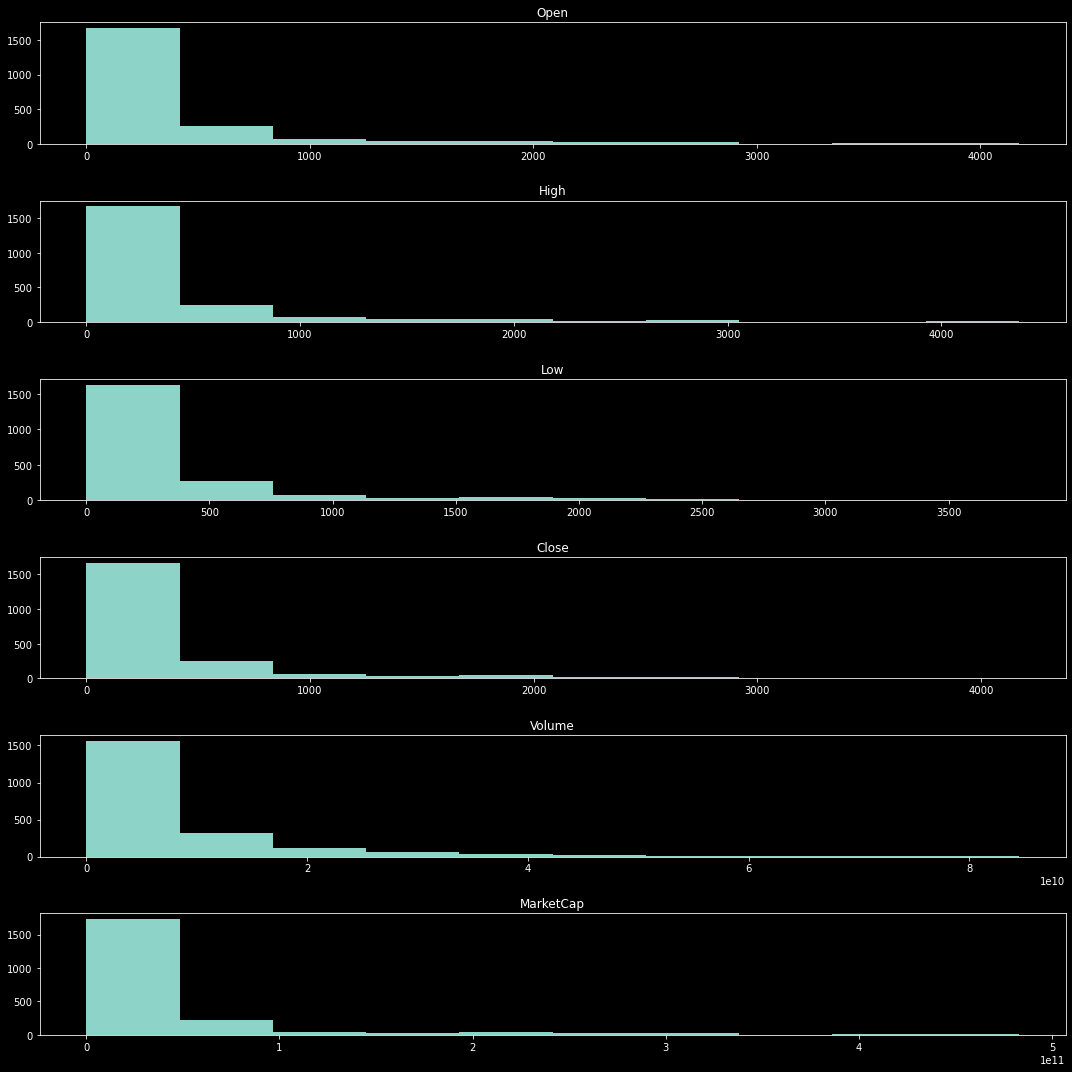

In [5]:
fig, ax = plt.subplots(6, figsize=(15,15))
for i, x in enumerate(list(df.columns)):
    ax[i].hist(df[x])
    ax[i].set_title(f'{list(df.columns)[i]}')
plt.tight_layout()

### Clean up the Graphs

The original time series was very hard to interpret because the volume column has very large numbers that messed with the scale of the graph. In order to remedy this, we will plot the price data and the volume data seperately, and we will resample the Volume data in order

In [6]:
# Plot the time series
fig = go.Figure()
col = ['Open', 'High', 'Low', 'Close']

# Add traces
for c in col:
    fig.add_trace(go.Scatter(x=df.index, y=df[c], mode='lines', name=f'{c}'))
fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price',
legend_title='Legend')
fig.show()
display(px.line(data_frame=df, x=df.index, y=df['Volume'], title='Volume Data'))

Target Variable

The trends of each series for each price related column (our target) are pretty much identical, so we can choose one of the features as a target variable and stick with that.
<br>

I will be using the "Close" price for Ethereum, which is the price of the asset at the close of normal trading hours at 4pm. 

### Resample Data (Week, Month, Year)

In [7]:
# Create resampled DataFrames

weekly_df = pd.DataFrame(df.resample('W').mean())
monthly_df = pd.DataFrame(df.resample('MS').mean())
yearly_df = pd.DataFrame(df.resample('YS').mean())

In [8]:
# Plot the time series
fig = go.Figure()

# Add traces
for c in col:
    fig.add_trace(go.Scatter(x=weekly_df.index, y=weekly_df[c], mode='lines', name=f'{c}'))
fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price',
legend_title='Legend')
fig.show()
display(px.line(data_frame=weekly_df, x=weekly_df.index, y=weekly_df['Volume'], title='Volume Data'))

### Autocorrelation Plots

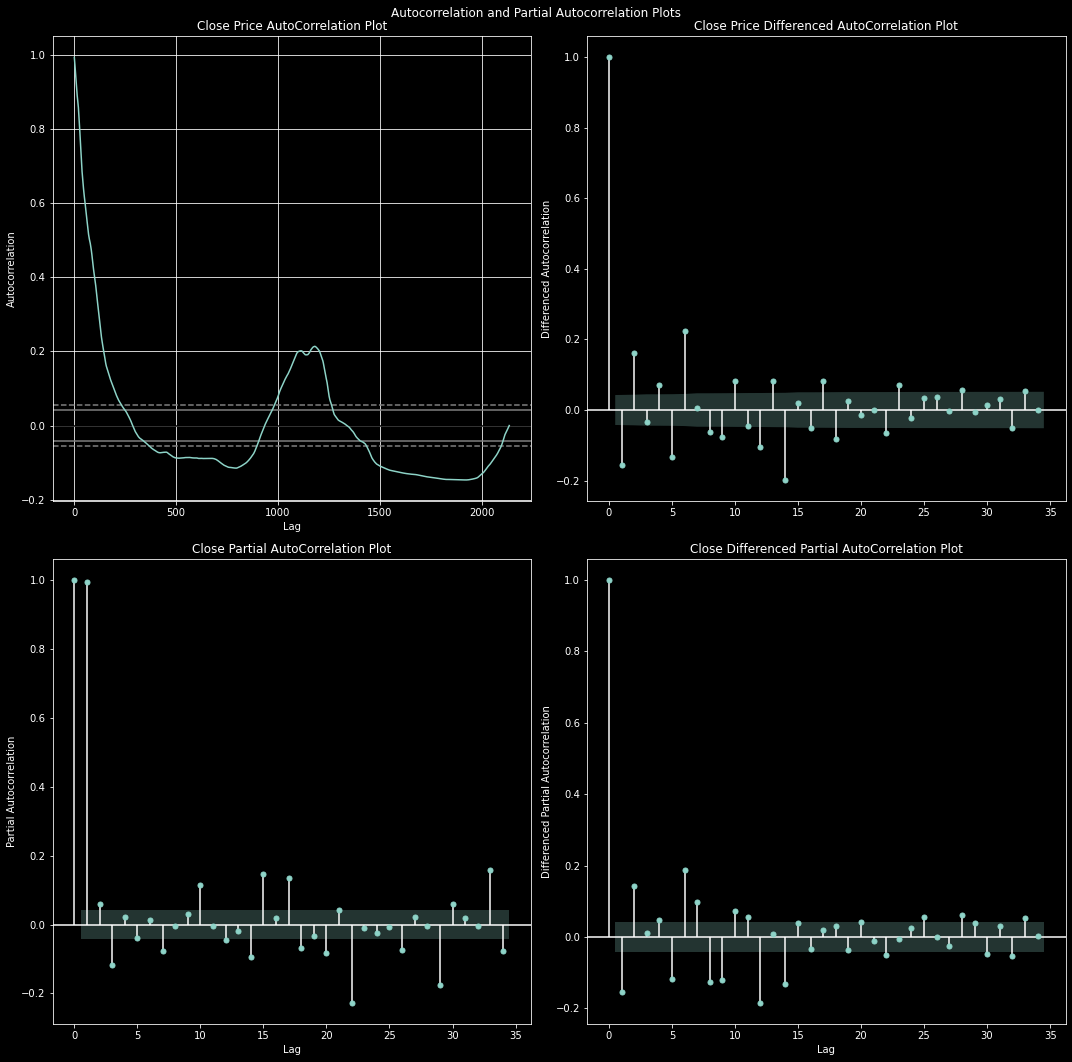

In [22]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

autocorrelation_plot(df['Close'].dropna(), ax=ax[0][0])
ax[0][0].set_title('Close Price AutoCorrelation Plot')

plot_acf(df['Close'].diff().dropna(), ax=ax[0][1])
ax[0][1].set_title('Close Price Differenced AutoCorrelation Plot')
ax[0][1].set_ylabel('Differenced Autocorrelation')

plot_pacf(df['Close'].dropna(), ax=ax[1][0])
ax[1][0].set_title('Close Partial AutoCorrelation Plot')
ax[1][0].set_xlabel('Lag')
ax[1][0].set_ylabel('Partial Autocorrelation')

plot_pacf(df['Close'].diff().dropna(), ax=ax[1][1])
ax[1][1].set_title('Close Differenced Partial AutoCorrelation Plot')
ax[1][1].set_xlabel('Lag')
ax[1][1].set_ylabel('Differenced Partial Autocorrelation')

plt.suptitle('Autocorrelation and Partial Autocorrelation Plots')
plt.tight_layout()

### Test Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

# ADF Test for Non-differenced target variable
result = adfuller(df['Close'], autolag='AIC')
print('NON-DIFFERENCED TARGET VARIABLE')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

print(' ')
print(' ')
# ADF Test for Differenced target variable
result = adfuller(df['Close'].diff().dropna(), autolag='AIC')
print('DIFFERENCED TARGET VARIABLE')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  
    
## THE RESULTS ARE WEIRD ON THIS
### THIS IS PROBABLY BECAUSE OF THE SUPER WEIRD INCONSISTENCY IN THE DATA (where those weird lines are jutting out in the line graph)

NON-DIFFERENCED TARGET VARIABLE
ADF Statistic: 1.0029061147236613
n_lags: 0.9942965169904011
p-value: 0.9942965169904011
Critial Values:
   1%, -3.4334573966160153
Critial Values:
   5%, -2.8629127187998606
Critial Values:
   10%, -2.5675007703726296
 
 
DIFFERENCED TARGET VARIABLE
ADF Statistic: -9.300900887869778
n_lags: 1.1132363356592992e-15
p-value: 1.1132363356592992e-15
Critial Values:
   1%, -3.4334573966160153
Critial Values:
   5%, -2.8629127187998606
Critial Values:
   10%, -2.5675007703726296


- A first-order difference is enough to stationarize the data

### Rolling Averages

In [11]:
# Full compiled graph of 30-day, 90-day, and 365-day rolling averages

fig = go.Figure()


df_30d_rol = df['Close'].rolling(window = 30).mean()
df_90d_rol = df['Close'].rolling(window = 90).mean()
df_365d_rol = df['Close'].rolling(window = 365).mean()
fig.add_trace(go.Scatter(x=df.index, y=df_30d_rol, mode='lines', name=f'30d Close'))
fig.add_trace(go.Scatter(x=df.index, y=df_90d_rol, mode='lines', name=f'90d Close'))
fig.add_trace(go.Scatter(x=df.index, y=df_365d_rol, mode='lines', name=f'365d Close'))

fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price',
legend_title='Legend')
fig.show()

### Seasonality

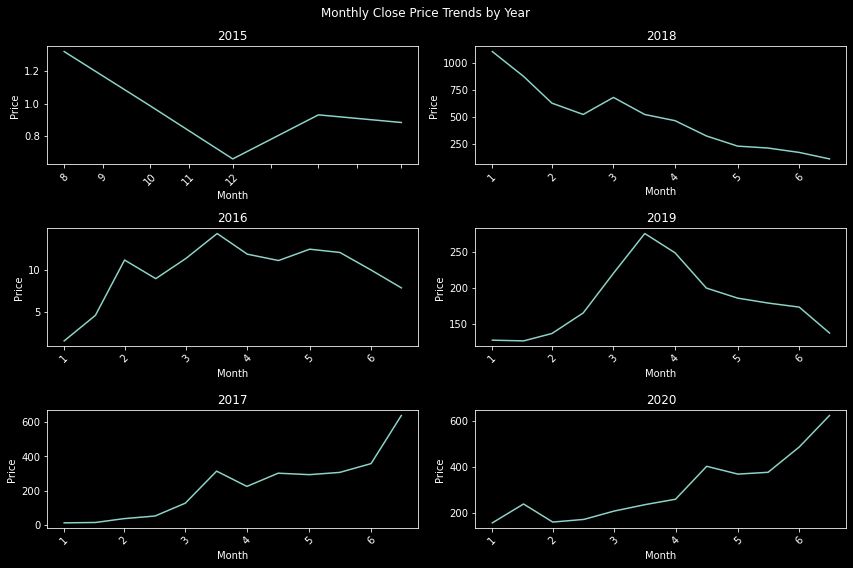

In [12]:
# Investigate Monthly Seasonality per Year

fig, ax = plt.subplots(3,2, figsize=(12, 8))

ax[0][0].plot(monthly_df['Close']['2015'])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('Month')
ax[0][0].set_ylabel('Price')
ax[0][0].set_xticklabels(labels=monthly_df['Close']['2015'].index.month,rotation=45)

ax[1][0].plot(monthly_df['Close']['2016'])
ax[1][0].set_title('2016')
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Price')
ax[1][0].set_xticklabels(labels=monthly_df['Close']['2016'].index.month,rotation=45)

ax[2][0].plot(monthly_df['Close']['2017'])
ax[2][0].set_title('2017')
ax[2][0].set_xlabel('Month')
ax[2][0].set_ylabel('Price')
ax[2][0].set_xticklabels(labels=monthly_df['Close']['2017'].index.month,rotation=45)


ax[0][1].plot(monthly_df['Close']['2018'])
ax[0][1].set_title('2018')
ax[0][1].set_xlabel('Month')
ax[0][1].set_ylabel('Price')
ax[0][1].set_xticklabels(labels=monthly_df['Close']['2018'].index.month,rotation=45)


ax[1][1].plot(monthly_df['Close']['2019'])
ax[1][1].set_title('2019')
ax[1][1].set_xlabel('Month')
ax[1][1].set_ylabel('Price')
ax[1][1].set_xticklabels(labels=monthly_df['Close']['2019'].index.month,rotation=45)


ax[2][1].plot(monthly_df['Close']['2020'])
ax[2][1].set_title('2020')
ax[2][1].set_xlabel('Month')
ax[2][1].set_ylabel('Price')
ax[2][1].set_xticklabels(labels=monthly_df['Close']['2020'].index.month,rotation=45)

plt.suptitle('Monthly Close Price Trends by Year')
plt.tight_layout()

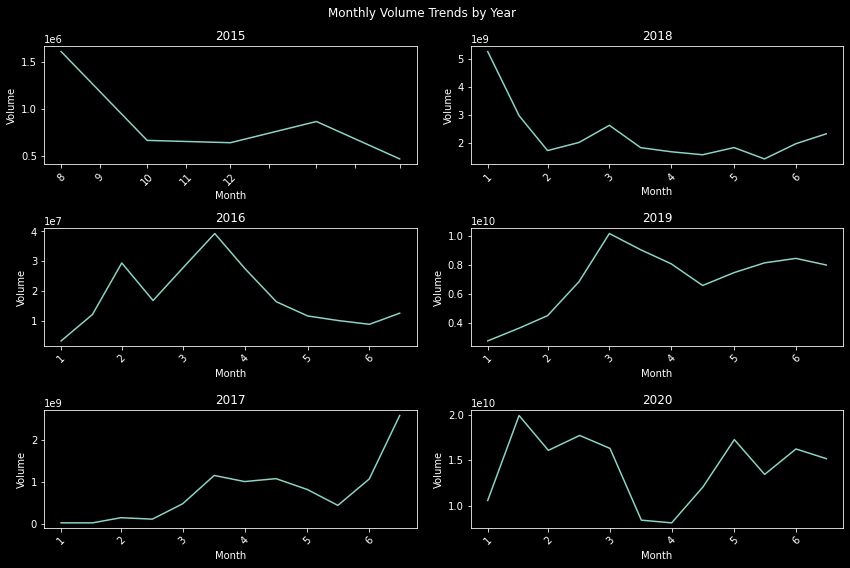

In [13]:
# Investigate Monthly Seasonality per Year

fig, ax = plt.subplots(3,2, figsize=(12,8))

ax[0][0].plot(monthly_df['Volume']['2015'])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('Month')
ax[0][0].set_ylabel('Volume')
ax[0][0].set_xticklabels(labels=monthly_df['Close']['2015'].index.month,rotation=45)

ax[1][0].plot(monthly_df['Volume']['2016'])
ax[1][0].set_title('2016')
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Volume')
ax[1][0].set_xticklabels(labels=monthly_df['Volume']['2016'].index.month,rotation=45)

ax[2][0].plot(monthly_df['Volume']['2017'])
ax[2][0].set_title('2017')
ax[2][0].set_xlabel('Month')
ax[2][0].set_ylabel('Volume')
ax[2][0].set_xticklabels(labels=monthly_df['Volume']['2017'].index.month,rotation=45)


ax[0][1].plot(monthly_df['Volume']['2018'])
ax[0][1].set_title('2018')
ax[0][1].set_xlabel('Month')
ax[0][1].set_ylabel('Volume')
ax[0][1].set_xticklabels(labels=monthly_df['Volume']['2018'].index.month,rotation=45)


ax[1][1].plot(monthly_df['Volume']['2019'])
ax[1][1].set_title('2019')
ax[1][1].set_xlabel('Month')
ax[1][1].set_ylabel('Volume')
ax[1][1].set_xticklabels(labels=monthly_df['Volume']['2019'].index.month,rotation=45)


ax[2][1].plot(monthly_df['Volume']['2020'])
ax[2][1].set_title('2020')
ax[2][1].set_xlabel('Month')
ax[2][1].set_ylabel('Volume')
ax[2][1].set_xticklabels(labels=monthly_df['Volume']['2020'].index.month,rotation=45)

plt.suptitle('Monthly Volume Trends by Year')
plt.tight_layout()

In [14]:
print(max(df['Close']['2015']))
print(max(df['Close']['2016']))
print(max(df['Close']['2017']))


2.77
20.59
826.82


In [15]:
min(df['Close']['2018'])/max(df['Close']['2018'])

0.06037581816358975

Ethereum prices follow what is called a "cyclical trend", which means that it has trends however these trends so no specific pattern of repetition. To illustrate this, we can look at two of the graphs, which are both displayed above. 

From the year 2015 to the first quarter of 2017, the price of Ethereum remained quite stationary, with a very strong rise starting between March and April, which led to a strong upwards trend that lasted throughout the rest of the year of 2017, bring the price to a maximum value of $826.82 by the end of the year. This constituted a 10,106% price increase from the minimum price of $8.17 in the year of 2017, which is by all standards a very strong upwards trend. The volume of trades also followed this trend quite closely, matching the sentiment idea that as an asset shoots up in price, more people attempt to join in on the ride, and hence more trades are made. After the year 2017, the price of Ethereum immediately started a strong downwards trend beginning in January of 2018, and by the end of 2018 the price had settled to a minimum value of $84.30, roughly a 94% drop from its all time high at the very beginning of 2018. Volume for the rest of 2018 remained on average higher than the two years afterwards and the year before because at first people were participating in frequent trades due to the meteoric rise in price, and then people continued to sell their coins over the year as the price tanked. From 2019 to mid-2020, the price once again mostly resumed the stationary trend that it had exemplified from 2015 to about a quarter of the way through 2017, indicating that perhaps people lost interest in the Ethereum block-chain, doubted its potential, or simply moved on to different investments. There was a sharp rise in prise to a little over $250 during 2019, but it just as quickly fell back to close to the minimum value of that year, failing to breakout of its strong downwards trend. The volume from 2019 to mid-2020 would never drop to the levels seen before the coin's meteoric rise, most likely because such a note-worthy event put Ethereum on the map permanently. During 2019, there was a sharp rise and fall in volume that mirrored the trend of the quick rise and fall of price during that year. 2019-2021 would be the period of time when Ethereum would consistently reflect a yearly upwards trend. Volume was higher than its ever been, and the price rose to an unprecedented level of roughly $4000. During this upwards trend, there were several downwards trends that occured during certain months of the years. They seemed to be relatively random, with no predictability in their occurences, highlighting the unstationarity of the price of Ethereum, and also the idea that the price follows a "cyclical trend". There are very clear bull and bear markets, however the trickly part is timing these.  



# Modeling

## ARIMA Model

In [83]:
### Train-Test-Split the Data
y_train = df['Close'][:'2019-06-13']
y_test = df['Close']['2019-06-14':] 

### Forecast

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1405
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6273.773
Method:                       css-mle   S.D. of innovations             21.039
Date:                Thu, 10 Jun 2021   AIC                          12555.546
Time:                        13:12:36   BIC                          12576.537
Sample:                    08-08-2015   HQIC                         12563.392
                         - 06-12-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1843      0.571      0.323      0.747      -0.934       1.303
ar.L1.D.Close    -0.8868      0.050    -17.821      0.000      -0.984      -0.789
ma.L1.D.Close     0.9184      0.042     

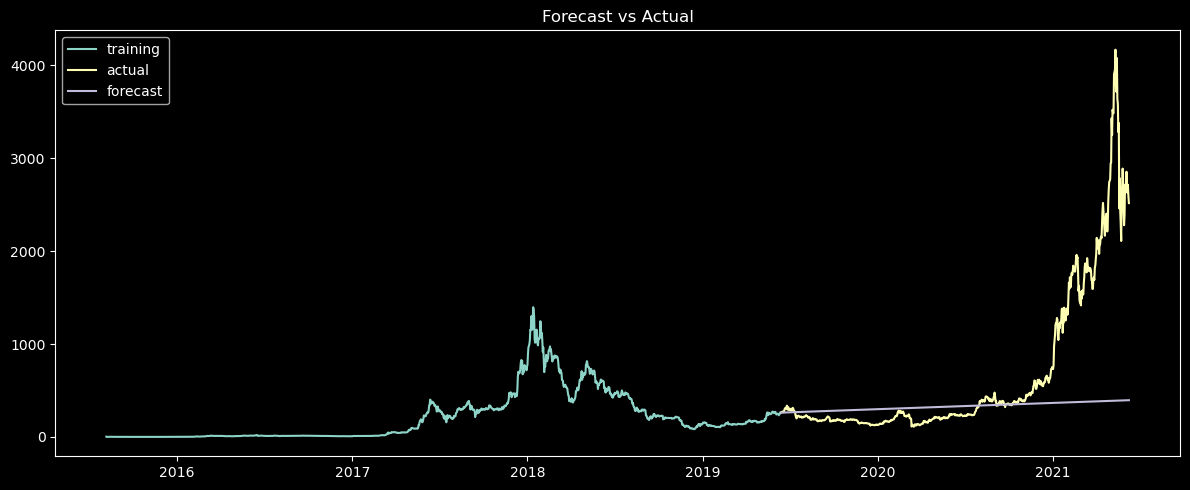

In [107]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

# Build a 1,1,1 ARIMA model
p, d, q = 1, 1, 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()


### Model Summary
print(model_fit.summary())


### Forecast
forecast, se, conf = fitted.forecast(726, alpha=0.05)


### Convert to series so we can plot the data
forecast_series = pd.Series(forecast, index=test.index)


### Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.title('Forecast vs Actual')
plt.legend(loc='upper left')
plt.tight_layout()

### Residuals

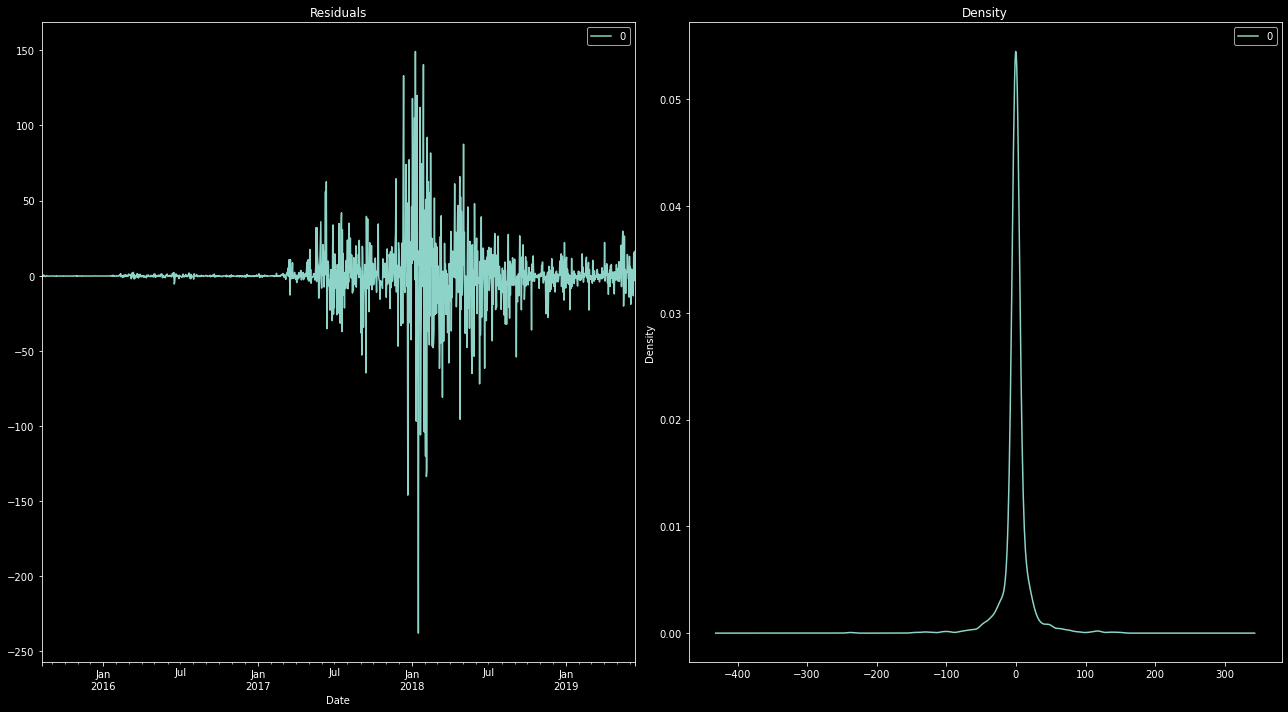

In [108]:
# Show residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(18,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.tight_layout()

## Sarima Model

In [ ]:
### Train_test_split
y_train = df['Close'][:'2019-06-13']
y_test = df['Close']['2019-06-14':] 

### Grid Search

In [121]:
import itertools
y=df['Close'].diff().dropna()
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    best_aic = float('+inf')
    
    
    for param in pdq:
        for s_param in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=s_param)

                results = mod.fit()
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    optimal_param = param
                    s_optimal_param = s_param

                    print(f'SARIMA{param}x{s_param} - AIC:{results.aic}')
            except:
                continue
    print(f'Optimal Parameters for SARIMA Model: SARIMA{optimal_param}x{s_optimal_param} - AIC:{best_aic}')


In [ ]:
### Grid Search

sarima_grid_search(y,180)

### Forecast

In [117]:
def sarima_and_plots(series, order, order_season, period_season, pred_date,test):
    
    
    
    ### Train model
    model = sm.tsa.statespace.SARIMAX(series, order=order, order_season=order_season)
    results = model.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    
    
    
    ### Root-Mean-Squared Error for One-Step_Ahead Forecast
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_confidence_interval = pred.conf_int()
    forecast = pred.predicted_mean
    mse = ((forecast - y_test) ** 2).mean()
    print(f'The Sarima RMSE for the One-Step-Ahead Forecast is {round(np.sqrt(mse), 2)}')




    ### Plot One-step Ahead Forecast
    ax = series.plot(label='Observed')
    forecast.plot(ax=ax, label='One-step Ahead Forecasting of Data', alpha=.7, figsize=(15, 10))
    ax.fill_between(pred_confidence_interval.index,
                    pred_confidence_interval.iloc[:, 0],
                    pred_confidence_interval.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    plt.legend()
    plt.show()




    ### Root-Mean-Squared-Error of Dynamic Forecast
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    forecast_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((forecast_dynamic - y_test) ** 2).mean()
    print(f'The Sarima RMSE for the Dynamic Forecast is {round(np.sqrt(mse_dynamic), 2)}')
    
    
    
    ### Plot Dynamic Forecast
    ax = series.plot(label='Observed')
    forecast_dynamic.plot(label='Dynamic Forecasting of Data', ax=ax,figsize=(15, 10))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.000   3048.675      0.000       0.999       1.000
ma.L1         -0.1187      0.006    -18.851      0.000      -0.131      -0.106
sigma2      2141.9742      9.994    214.321      0.000    2122.386    2161.563


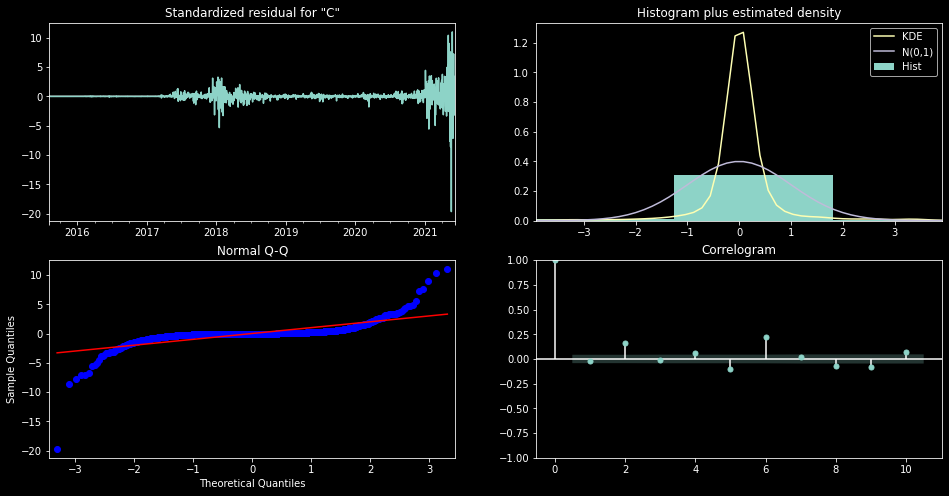

The Sarima RMSE for the One-Step-Ahead Forecast is 73.56


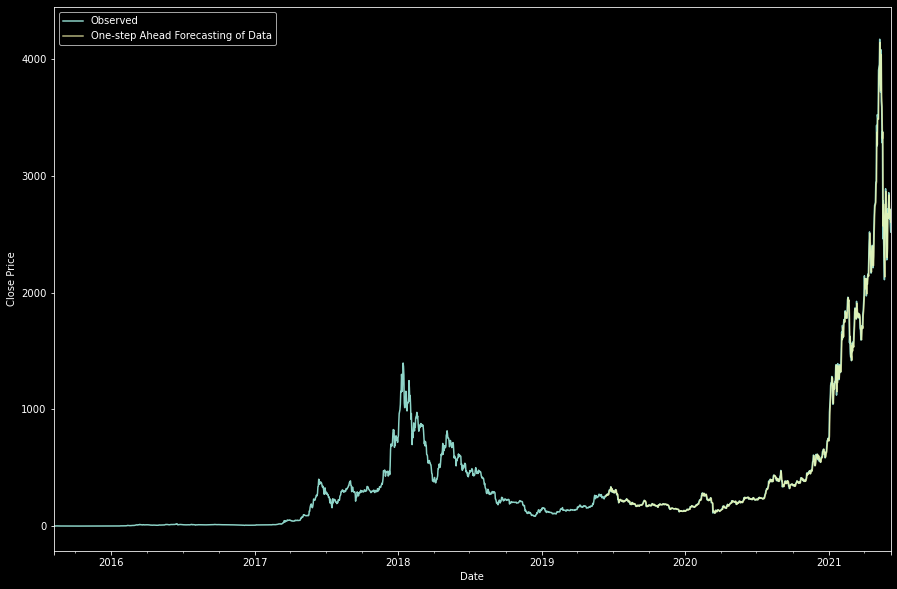

The Sarima RMSE for the Dynamic Forecast is 945.51


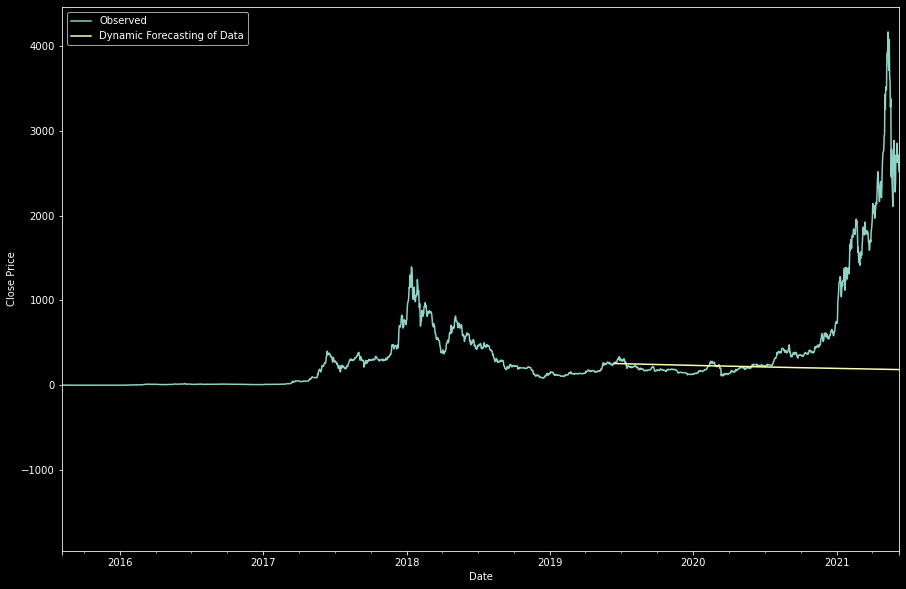

In [118]:
series = df['Close']
model = sarima_and_plots(series, (1, 0, 1), (0, 1, 1, 52), 30, '2019-06-14', y_test)